In [1]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np

# Question 1

Simulate a time series with $n = 500$ realisations distributed according to a probability law $L$ of your choice. This time series must have $K^∗ ≥ 2$ changes in one or more dimensions of the parameters of $L$ (you set the value of $K^∗$ as you wish). Plot this time series.

## Answer 1

We choose an Exponential distribution for the time series simulation, the code below shows the function `expovariate`, which crate functions that generates random values of exponential distibution with mean $ \lambda = l$. 

In [2]:
def expovariate(l):
    return lambda : random.expovariate(l)

In [3]:
#Lets initialize 3 functions exp_1, exp_4 and exp_5, using expovariate in order to get funcions that generate 
#random values of exponential distribution with lambdas = 1,4,5 respectively

exp_1 = expovariate(1)
exp_4 = expovariate(4)
exp_5 = expovariate(5)

In [6]:
#Given the times sires inteval, the moments of the change points and the distibution function for gerate the values 
# in each segment of the time series, this function returns the time series simulated

def generate_time_series(interval,
                         change_points,
                         distributions):
    '''
    `interval`: 
    `change_points`: 
    `distributions`:
    '''
    time_series = []
    points =  [interval[0]] + change_points + [interval[1]]
    for p in range(len(distributions)):
        point_left = points[p]
        point_right = points[p + 1]
        for _ in range(point_left, point_right, 1):
            time_series.append(distributions[p]())
    return time_series


In [7]:
#Given time series, this function plots the times series, if change points are also given then includes gray dashed lines on 
#change points and if the aproximation values for change points are given too, plots red dashed lines on those
#values too

def plot_time_series(time_series, change_points= None, approx_change_points= None):
    plt.plot(range(len(time_series)), time_series, '.', color= 'black')
    min_point = min(time_series)
    max_point = max(time_series)
    if change_points is not None:
        for change_point in change_points:
            plt.vlines(change_point, min_point, max_point, colors= 'gray', linestyles='dashed')
    if approx_change_points is not None:
        for change_point in approx_change_points:
            plt.vlines(change_point, min_point, max_point, colors= 'red', linestyles='dashed')
    plt.show()

Now let's generate a time serie on time interval $[0; 500]$, and let's add 3 change points on $200$, $250$ and $300$, for that we generate random exponentialy distributed values, using the previously defined functions exp_1, exp2 adn exp_3, getting $4$ intervals $[0; 200)$, $[200,250)$, $[250;300)$ and $[300,500]$ with values coresponding to exponential distributions with $\lambda = 1,5,1,4$ respectively using `generate_time_series` function. Finally we plot the resulting time series and the real change points moments with `plot_time_series` function.

In [8]:
interval = (0, 500)
change_points = [200, 250, 300]
distributions = [exp_1, exp_5, exp_1, exp_4]
time_series = generate_time_series(interval, change_points, distributions)

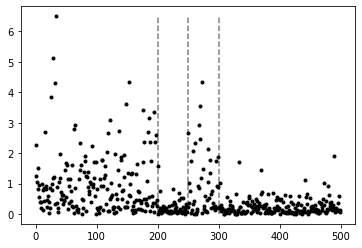

In [9]:
plot_time_series(time_series, change_points)

# Question 2

Derive a cost function that is appropriate for the data simulated in Question 1. Briefly justify your choice (in a comment in your code).

## Answer 2


Assuming the fact that time series has exponential distribution is known, but the mean($\lambda$) of the distribution on each interval, splitted by change points, is not known. Then we are going to use the negative logarithm of likelihood function. Let's start finding those $\lambda$ values, for which the value of this function is minimal, keeping constant $y_i$ (value of time series at instant $i$) values for all  $0 < i \le n$. Note that find the minimum value, is equivalent to find the maximum in the possitive function, and that can be done finding the **maximum likelihood estimator**. Given $y_i$, we must maximice:

<!-- Supongamos que sabemos que los puntos simulados tienen distribución exponencial pero no sabemos con qué parámetro $\lambda$, para cada uno de los intervalos entre `CP` y `CP`. Para ello utilizaremos como función de costo el logaritmo negativo de la función de verosímilitud. Pero antes debemos hallar para qué valor de $\lambda$ este valor es mínimo manteniendo constante los valores de $y_i$ para todo $0 < i \le n$. Note que hallar el valor mínimo es equivalente a hallar el valor máximo de la misma función positiva, lo cual sería el método del máximo verosímil. Dada cada $y_i$, debemos maximizar: -->

$$ L(\lambda | y_1...y_n) = Π_{i=1}^n \lambda e^{-\lambda y_i}  = \lambda^n e^{-\lambda \sum_{i = 1}^{n} y_i} $$

Which is equivalent to maximice:
<!-- Sin embargo esto es equivalente a maximizar: -->

$$ \ln(\lambda^n e^{-\lambda \sum_{i = 1}^{n} y_i}) = \ln(\lambda^n) + \ln(e^{-\lambda \sum_{i = 1}^{n} y_i}) = n\ln(\lambda) -\lambda \sum_{i = 1}^{n} y_i $$

At last we derive and make the function equal $0$, in order to find such value:
<!-- Por último derivamos e igualamos a $0$ para encontrar este valor: -->

$$ 0 = \frac{dL(n\ln(\lambda) -\lambda \sum_{i = 1}^{n} y_i)}{d\lambda} = \frac{n}{\lambda} - \sum_{i = 1}^{n} y_i$$

Finally we get the estimated expression value of $\lambda$:
<!-- Y finalmente obtenemos que el valor estimado de $\lambda$ es: -->

$$ \lambda_{MLE} = \frac{n}{\sum_{i = 1}^{n} y_i}$$

With the estimated $\lambda$, we go back on our possitive cost function and replace $\lambda$ expression on it:
<!-- Ahora bien, estimado $\lambda$ regresamos a nuestra función de costo versión positiva y sustituimos obteniendo: -->

$$ n\log(\lambda_{MLE}) -\lambda_{MLE} \sum_{i = 1}^{n} y_i = n\log \left(\frac{n}{\sum_{i = 1}^{n} y_i} \right) - \frac{n}{\sum_{i = 1}^{n} y_i} \sum_{i = 1}^{n} y_i$$ 
$$ = n\log \left(\frac{n}{\sum_{i = 1}^{n} y_i} \right) - n = n \left(\log \left(\frac{n}{\sum_{i = 1}^{n} y_i} \right) - 1\right) $$

But, the purpose of this in the end is minimaze this value at the change points, so we need to work with the opposite, the negative of this function, the original cost function, so it is:
<!-- Pero como lo que queremos es minimizar más adelante con nuestros algoritmos de búsqueda de puntos de ruptura, lo que haremos es trabajar con el opuesto de este, lo que quedaría: -->

$$ n \left(1 - \log \left(\frac{n}{\sum_{i = 1}^{n} y_i} \right) \right) $$

Let's rename this cost function for an easier aplication on intervals $[a;b]$ of time series:
<!-- Para formalizar más la función de costo, utilizaremos la notación: -->

$$ c(y_{a:b}) = n \left(1 - \log \left(\frac{n}{\sum_{i = a}^{b} y_i} \right) \right) $$

donde $n = b-a+1$.

In [ ]:
#Function that given the values on an interval if time series compute the cost function for the interval
def cost_funtion_exp(points):
    n = len(points)
    if n == 0:
        return 0     
    return n * (1 - math.log(n / sum(points)))

# Question 3

Implement the optimal partition algorithm and test it on the data simulated in question 1.

## Answer 3

The following code is an imoplementation of  `Optimal Partition` algorithm, it receives as data:

- The time series
- The cost function
- The amount on change points

In [ ]:
def OptimalPartition(points, cost_func, K):

    n = len(points)
    Ms = np.zeros((K,n,n)) #Initialize the arrays
    for u in range(n):
        for v in range(n):
            if u < v:
                Ms[0][u][v] = cost_func(points[u:v+1]) #The initial values (base case) of dp

    if K > 1: #Fill the arrays using dp 
        for k in range(1, K):
            for u in range(n):
                for v in range(n):
                    if v-u > k+1:
                        Ms[k][u][v] = min([Ms[k-1][u][t] + Ms[0][t+1][v] for t in range(u+k-1, v)])
    L = np.zeros((K+1), dtype=int) #List of change points
    L[K] = n-1  
    k = K
    while k > 0: #Find the change points using the pre-computed values on dp arrays 
        s = L[k]        
        ts = [Ms[k-1][0][t] + Ms[0][t+1][s] for t in range(k, s)]
        ts_min =  min(ts)
        t_index = ts.index(ts_min)
        L[k-1] = t_index
        k= k -1
    return L[:-1]
    

We then use the `OptimalPartition` algorithm to predict the change points on teh previously simulated data, the results are shown below.

In [ ]:
approx_change_points_OP = OptimalPartition(time_series, cost_funtion_exp, 3)
approx_change_points_OP

array([197, 247, 296])

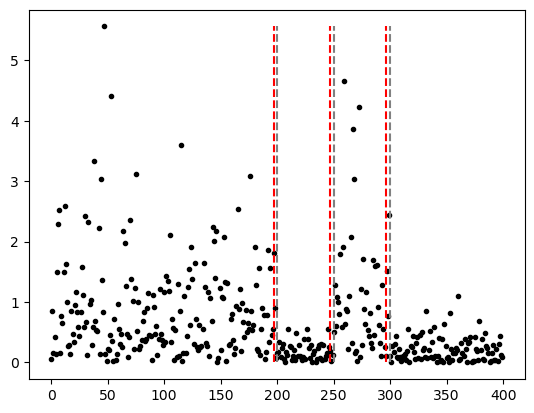

In [ ]:
plot_time_series(time_series, change_points, approx_change_points_OP)

# Question 4

Implement the PELT algorithm and test it using the data simulated in question 1. You will set the value of the penalty weight as $log(n)$.

## Respuesta 4

A continuación se hace una implementación del algoritmo `PELT`. Nos basamos tanto en la implementación de Conferencia como la explicada en el artículo **"Killick, R., Fearnhead, P., & Eckley, I. A. (2012, oct). Optimal detection of changepoints with a linear computational cost. Journal of the American Statistical Association"**. Es importante señalar que PELT hace uso del **Teorema 3.1** de este artículo para descartar posibles puntos de cambios. Este Teorema expresa lo siguiente:

[ALE porfa por tu el teorema sencillito que no tiene sentido q lo traduzca al español pa que lo pongas luego en inlges. Solo hace falta el enunciado, NO la demostración]

Luego el pseudocódigo de nuestro algoritmo sería:

**Input**:
- `data` $= \{y_1,...,y_n\}$: conjunto de puntos
- $c(.)$: función de costo
- $\beta$: peso de penalización
- `K`: constante que satisface **Teorema 3.1**
- $n_{min}$: tamaño de intervalo mínimo

**Initialisations**:
- `F` = $(-\beta,..., n_{min}-1 = -\beta, 0,...,0)$: vector de tamaño `n`
- `R` = $\{0\}$: conjunto inicial de posibles puntos de cambios
- `CP` = $(0,...,0)$: array de puntos de cambios asociados a cada dato

**Pseudo-Code**:

- **for all** $t^* = n_{min},..., n-1$:  
    - $F[t^~] = \min_{t \in R  ~ | ~ |t^~-t| \ge n_{min} }\{F(t) + c(y_{t:t^~})+ \beta\}$
    - $\overline{t} = \argmin_{t \in R  ~ | ~ |t^~-t| \ge n_{min} }\{F(t) + c(y_{t:t^~-1})+ \beta\}$
    - $ CP[t^~] = \overline{t} $
    - $ R^* = \{ t^~ \} \cup \{ t \in R ~ | ~ F[t] + c(y_{t:t^~-1}) + K < F[t^~]\} $
    - $ R = R^*$
- **end for**
- `last = CP[n-1]`
- **while** `last != 0` :
    - **add** `last` **to** `changes_points`
    - `last = CP[last]`
- **end while**  

**Output**
- `changes_points`: Changes Points

In [ ]:
def PELT(points, cost_func, penalty= None, n_min=0, K= 0):

    n = len(points)
    F = np.zeros(n, np.float32)

    if penalty is None:
        penalty = np.log(n)

    for i in range(n_min):
        F[i] = - penalty
    CP = np.zeros(n, np.int32)
    R = np.array([0], dtype=np.int32)

    for t_accent in range(n_min, n):
        
        np.array(F[t_accent])         
        interval_costs = np.zeros(R.shape[0], np.float32)
        interval_costs_pen = []
        for i, change_point_cand in enumerate(R):            
            interval_costs[i] = F[change_point_cand] + cost_func(points[change_point_cand: t_accent])
            if abs(R[i] - t_accent) >= n_min:
                interval_costs_pen.append((interval_costs[i] + penalty, R[i]))

        F[t_accent], CP[t_accent] = min(interval_costs_pen)
        
        R_new = []
        for i, val in enumerate(interval_costs):
            if val + K < F[t_accent]:
                R_new.append(R[i])
        R_new.append(t_accent)
        R = np.array(R_new, dtype=np.int32)

    finals_CP = []
    last = CP[-1]
    while last > 0:
        finals_CP.append(last)
        last = CP[last]
    finals_CP.reverse()
    return finals_CP

Por último para PROBAR nuestro implementación utilziaremos el conjunto de datos simulados, y tomaremos como:

- $\beta = \log(n)$
- $K = 0$ ya según el artículo mencionado, es con este valor que se satisface el **Teorema 3.1**

Los resultados obtenidos se muestran a continuación:

In [ ]:
approx_change_points_PELT = PELT(time_series, cost_funtion_exp)
approx_change_points_PELT

[199, 250, 300]

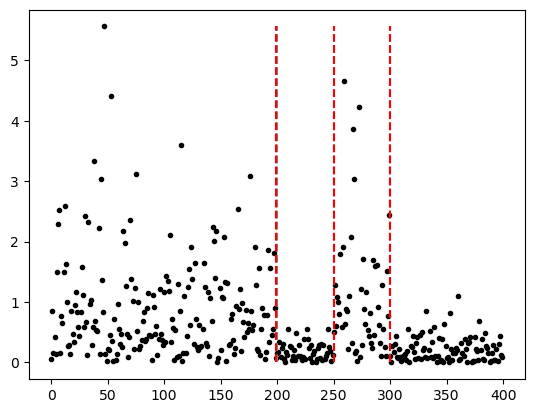

In [ ]:
plot_time_series(time_series, change_points, approx_change_points_PELT)

# Question 5

Test the PELT algorithm with other values of the penalty weight. Comment the results.

In [ ]:
approx_change_points_PELT_2 = PELT(time_series, cost_funtion_exp, penalty= 1/2 * np.log(len(time_series)))
approx_change_points_PELT_2

[199, 250, 300]

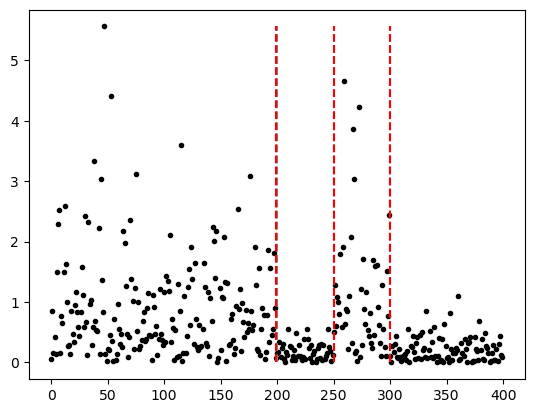

In [ ]:
plot_time_series(time_series, change_points, approx_change_points_PELT_2)